Markov chain procedural name generation
===

The Model
---
In this notebook we develop a model for procedural name generation tool using [Markov chains](https://en.wikipedia.org/wiki/Markov_chain).
We are given a set of names and are tasked with generating new ones which are similar but ideally not the same.
We will use [n-grams](https://en.wikipedia.org/wiki/N-gram) extracted from the data set to derive a transition matrix of a Markov chain which can then, in turn, be used to generate new names letter by letter.
Every state of the Markov chain represents a currently observed n-gram (plus a few special states) and the transition probabilities are based on the conditional probabilities of observing the next letter (or n-gram) in the training set.

First we will only consider 1-grams, i.e. single letters. We say the model has a memory of 1. The state space of our Markov chain is then given by
$$ V = \{ \hat{}, \$, a, b, \dots, y, z \} $$
where the $\hat{}$ represents the start of a word and the $\$$ represents the end of a word.
Say our training set is a bit boring and only consists of the words "abc" and "xbz".
Then our model should end up with the transition probabilities
$$\begin{align}
p(\hat{} \to a) = p(\hat{} \to x) &= 0.5 \\
p(a \to b) &= 1 \\
p(x \to b) &= 1 \\
p(b \to c) = p(c \to z) &= 0.5 \\ 
p(c \to \$) &= 1 \\
p(z \to \$) &= 1 \\
\end{align}$$
where all other probabilities are zero.
In order to sample a new word from the chain, we start in the state $\hat{}$ and keep sampling the next state until we end up in $\$$, keeping track of the states we visited along the way.
Every state then represents one letter in the generated name.
For our simple training set, the set of all words we can possibly generate is given by
$$\{abc, xbz, abz, xzc\}.$$

In the case where we consider 2-grams or more (i.e. the memory of the model grows), the chain will have one state for every possible n-gram.
The training and sampling procedures will remain the same but when generating a new word, we have to only consider the last (or first) letter in every n-gram we visit as part of the generated name.

Your Tasks
---
You are already provided with some data sets (feel free to add your own) and code to handle the mapping from n-grams to state indices and back. You tasks are to:

  1. Extract the transition probabilities from the training set and represent it using NumPy arrays
  2. Sample a new name using Python generators
  3. OPTIONAL: Come up with filters to improve the output
  4. Sample a new name using NumPy facilities
  5. Vectorize the NumPy-Solution
  6. Compare running times
  
Our goal in the end is to be able to sample very large amounts of names from our Markov chain.

# Imports and settings

In [1]:
import itertools as it
import timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Optional for nicer plots
sns.set()

In [3]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['figure.dpi'] = 110

# Datasets

In [4]:
def read_names(filename):
    with open('data/{}'.format(filename), 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

name_lists = {
    identifier: read_names(identifier)
    for identifier in [
        'debug',
        'german_male', 'german_female',
        'english_male', 'english_female',
        'egypt_gods', 'norse_gods',
        'angels', 'demons',
    ]
}

In [5]:
name_lists['norse_gods'][:10]

['odin',
 'thor',
 'baldur',
 'njörd',
 'freyr',
 'tyr',
 'bragi',
 'heimdall',
 'höd',
 'vidar']

# States of the Markov chain

In [6]:
delimiters = ['^', '$']
vowels = ['a', 'e', 'i', 'o', 'u', 'ö', 'ü', 'ä']
consonants = [
    'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k',
    'l', 'm', 'n', 'p', 'q', 'r', 's', 't',
    'v', 'w', 'x', 'y', 'z',
]
characters = sorted(it.chain(vowels, consonants))
reverse_characters = {char: ix for ix, char in enumerate(characters)}
state_base = len(characters)

In [7]:
def state_index(chars):
    if chars in delimiters:
        return delimiters.index(chars)
    else:
        offset = len(delimiters) + sum(len(characters) ** b for b in range(1, len(chars)))
        return offset + sum(
            reverse_characters[char] * state_base ** exponent
            for exponent, char in enumerate(reversed(chars))
        )
    
    
def state_labels(memory=1):
    return list(it.chain(
        delimiters,
        *(
            map(''.join, it.product(characters, repeat=repeat))
            for repeat in range(1, memory + 1)
        )
    ))    


def last_character(state):
    if state < len(delimiters):
        return delimiters[state]
    else:
        return characters[(state - len(delimiters)) % state_base]


def recover_string(states):
    return ''.join(map(last_character, states)).strip(''.join(delimiters))


def recover_all_strings(statess):
    return [
        recover_string(states)
        for states in statess
    ]

In [8]:
start_index = state_index('^')
end_index = state_index('$')

In [9]:
for string in ['^', '$', 'a', 'b', 'z', 'ü', 'aa', 'ab', 'ba', 'zz', 'aaa', 'üüü']:
    print('Index of state {:>3}: {}'.format(string, state_index(string)))

Index of state   ^: 0
Index of state   $: 1
Index of state   a: 2
Index of state   b: 3
Index of state   z: 27
Index of state   ü: 30
Index of state  aa: 31
Index of state  ab: 32
Index of state  ba: 60
Index of state  zz: 781
Index of state aaa: 872
Index of state üüü: 25260


In [10]:
last_character(state_index('a')), last_character(state_index('abc'))

('a', 'c')

In [11]:
recover_string([state_index(char) for char in 'siemens'])

'siemens'

In [12]:
recover_all_strings([
    [state_index(char) for char in 'ingenuity'],
    [state_index(char) for char in 'for'],
    [state_index(char) for char in 'life'],
])

['ingenuity', 'for', 'life']

# Creating a transition matrix

Markov chains are often represented using transition matrices.
If $N$ is the number of states in a markov chain, its corresponding transition matrix $T$ is of size $N \times N$ and it holds that
$$T_{ij} = p(i \to j),$$
i.e. the entry in the $i$th line and $j$th column represents the probabilitiy to transition from state $i$ to state $j$.
Note that this implies that for all $i$,
$$\sum_j T_{ij} = 1.$$
Do you understand why?

In this section we want to derive the transition matrix corresponding to a training set.
The first section provides code which translates the incoming words to the observations of state transitions we are interested in.
In the second section, you job is to actually generate the transition matrix.

## Handling the input

In [13]:
def windowed(iterable, size):
    """Create a sliding window iterator over iterable.
    
    Given iterable=[a, b, c, d] and size=3, the result is a generator containing [(a, b, c), (b, c, d)]
    """
    parts = it.tee(iterable, size)

    for skip, part in enumerate(parts):
        for _ in range(skip):
            next(part, None)

    return zip(*parts)

In [14]:
def name_to_state_pairs(name, memory):
    states = it.chain(
        '^', # Start state
        (tuple(name[:m]) for m in range(1, memory)), # Initial memory-free letters
        windowed(name, memory), # Letters with memory
        ['$'], # End state
    )
    return windowed(map(state_index, states), 2)

In [15]:
list(name_to_state_pairs('abcdef', memory=1)), list(name_to_state_pairs('abcdef', memory=2))

([(0, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 1)],
 [(0, 2), (2, 32), (32, 62), (62, 92), (92, 122), (122, 152), (152, 1)])

## Creating the matrix

In [16]:
def create_transition_matrix(names, memory):
    number_of_states = len(state_labels(memory))
    matrix = np.zeros((number_of_states, number_of_states))

    matrix[end_index, end_index] = 1
    for name in names:
        for left, right in name_to_state_pairs(name, memory):
            matrix[left, right] += 1

    sums = matrix.sum(axis=1)
    sums[sums == 0] = 1
    matrix /= sums[:, None]
    return matrix

In [17]:
# You will probably want to set memory to 1 for most debugging purposes
memory = 1

transition_matrix = create_transition_matrix(name_lists['angels'], memory=memory)
# We will need this later
cumulative_transition_matrix = np.cumsum(transition_matrix, axis=-1)

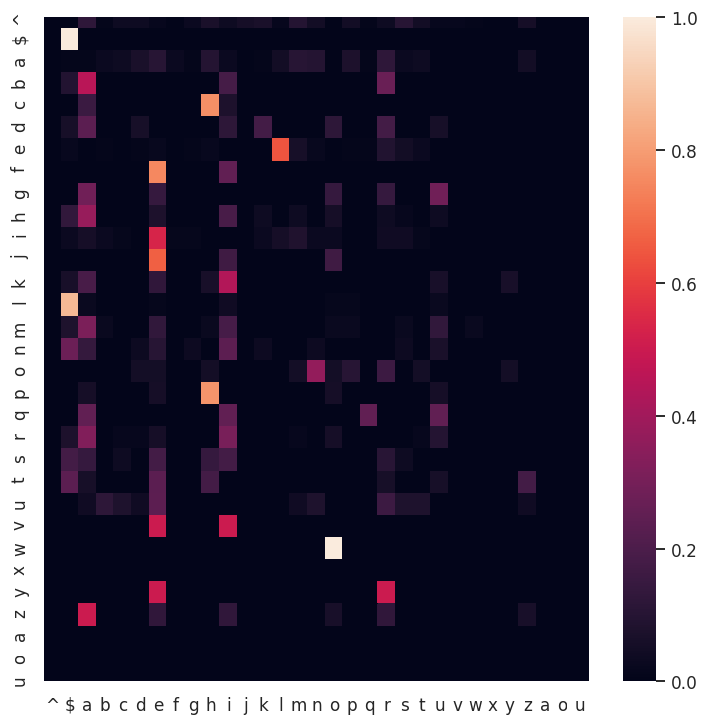

In [18]:
sns.heatmap(transition_matrix, xticklabels=state_labels(memory), yticklabels=state_labels(memory))

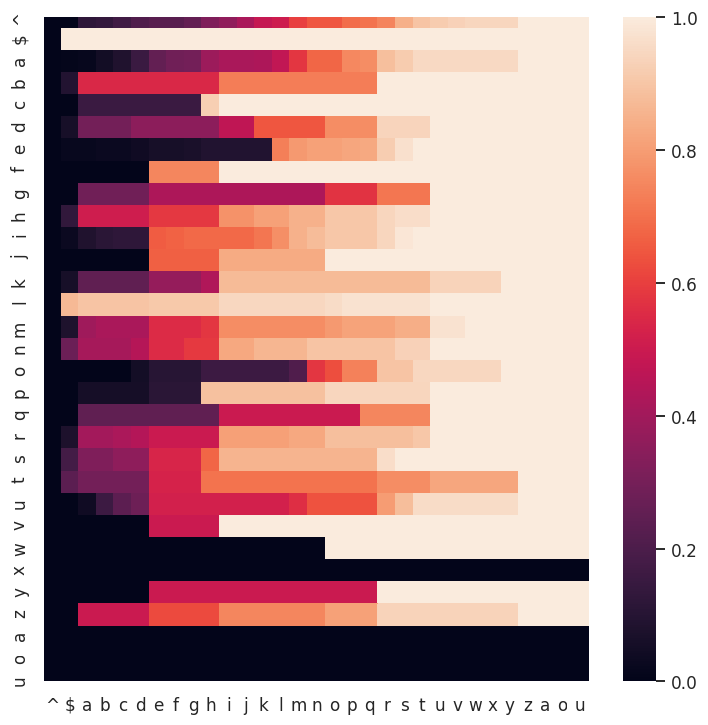

In [19]:
sns.heatmap(cumulative_transition_matrix, xticklabels=state_labels(memory), yticklabels=state_labels(memory))

# Sampling single new names: The Python way

Now that we have "trained" the model, we want to sample new names from it.
We will start with a baseline solution to this which uses python generators to sample single names and will improve on this later using NumPy.
You job is to implement this sampling process. But first you should find out how to use NumPy's `np.random`-Module to sample from discrete probabilitiy distributions.

## Single discrete samples from a probability distribution

In [20]:
probabilities = np.array([0.1, 0.2, 0.7])
# Find or write a function which returns one of the numbers 0, 1 or 2 with respective probabilities 0.1, 0.2 and 0.7.

np.random.choice(probabilities.size, p=probabilities)

1

## Single samples from a Markov chain

In [21]:
def sample_name_generator(cumulative_transition_matrix, max_length=12):
    state = start_index

    for _ in range(max_length):
        cdf_sample = np.random.uniform()
        state = (cumulative_transition_matrix[state] <= cdf_sample).sum()

        if state == end_index:
            break
        else:
            yield state

In [22]:
def from_generator(num_names):
    return [list(sample_name_generator(cumulative_transition_matrix)) for _ in range(num_names)]

In [23]:
recover_all_strings(from_generator(15))

['mamarunamiel',
 'sel',
 'vel',
 'al',
 'tzel',
 'sachael',
 'zanin',
 'mapadkahimue',
 's',
 'wodduem',
 'nel',
 't',
 'anuniel',
 'zan',
 'imiegamua']

In [24]:
%timeit from_generator(10 ** 3)

66.4 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# OPTIONAL: Recovering the good names

The strings sampled from the model will often not really look like names.
A common solution to this problem is to just sample more strings and only keep the ones which match some criteria for nice names.
You can skip this task, implement suggested filters or come up with your own.

In [25]:
filters = [
    lambda x: 3 < len(x) < 10,
    # Some additional ideas:
    # - A maximum length
    # - Forbid 3 or more consecutive consonants
    lambda x: not any(all(c in consonants for c in window) for window in windowed(x, 3)),
]


def nice_names(names):
    def passes_all_filters(name):
        return all(filter(name) for filter in filters)
    
    return list(filter(passes_all_filters, names))

In [26]:
nice_names(recover_all_strings(from_generator(20)))

['phabaniel',
 'diel',
 'zierah',
 'zatel',
 'nuel',
 'uerannubi',
 'madan',
 'raris',
 'kial',
 'dkuatzar',
 'mimel',
 'zahrel',
 'heel',
 'riehmal']

# Sampling single new names: The NumPy way

Instead of using Python's generators, we now want to use NumPy to speed up sampling from the Markov chain.
Our goal is to sample many names at the same time (using one function call) instead of one name per Python generator.
This is called "vectorizing" the operation.

Before doing that we will implement the sampling of single names using NumPy as an intermediate step.
The `sample_name_numpy` function should return a numpy array of dtype `np.int` containing the states you visited in the chain during sampling.

In [27]:
def sample_name_numpy(cumulative_transition_matrix, max_length=12):
    state = np.full(max_length, end_index, dtype=np.int) # Why is this sensible?
    state[0] = start_index

    for ix in range(1, max_length):
        cdf_sample = np.random.uniform()
        state[ix] = (cumulative_transition_matrix[state[ix - 1]] <= cdf_sample).sum()

        if state[ix] == end_index:
            break

    return state

In [28]:
def from_numpy(num_names):
    return [sample_name_numpy(cumulative_transition_matrix) for _ in range(num_names)]

In [29]:
nice_names(recover_all_strings(from_numpy(15)))

['nkel', 'qiel', 'razaraph', 'wonira']

In [30]:
%timeit from_numpy(10 ** 3)

73.2 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Sampling multiple new names

Now that we can use NumPy to sample single names from out model, we want to vectorize this operation and sample multiple names at once.
The function `sample_names_vectorized` should return a 2D-array which contains one sample from the Markov chain per line.
To achieve this in a fast way, you will need to sample from multiple discrete probability distributions at once.

## Discrete samples from multiple probability distributions

In [31]:
probabilitiess = np.array([
    [0.1, 0.2, 0.7],
    [0.2, 0.3, 0.5],
    [0.3, 0.4, 0.3],
    [0.5, 0.3, 0.2],
    [0.7, 0.2, 0.1],
])
# Find a function which, given the probabilitiess vector, returns a 1D-array of samples of size 5, one sample for each line.
# There is no NumPy-function which directly implements this, so try to implement it yourself using other np.random functions.
# You should NOT use a loop to achieve this.

(probabilitiess.cumsum(axis=-1) <= np.random.uniform(size=(len(probabilitiess), 1))).sum(axis=-1)

array([2, 1, 2, 0, 0])

## Multiple samples from a Markov chain at the same time

In [32]:
def sample_names_vectorized(cumulative_transition_matrix, num_names=1, max_length=12):
    states = np.full((num_names, max_length), end_index, dtype=np.int) # Why is this sensible?
    states[:, 0] = start_index

    for column in range(1, max_length):
        cdf_sample = np.random.uniform(size=(num_names, 1))
        cprobs = cumulative_transition_matrix[states[:, column - 1]]
        states[:, column] = (cprobs <= cdf_sample).sum(axis=1)

    return states

In [33]:
def from_vectorized(num_names):
    return sample_names_vectorized(cumulative_transition_matrix, num_names=num_names)

In [34]:
nice_names(recover_all_strings(from_vectorized(15)))

['thaqurat', 'athie', 'amahkir', 'wonuci', 'wonutzel', 'madrel']

In [35]:
%timeit from_vectorized(10 ** 3)

1.74 ms ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
def sample_names_vectorized_presample(cumulative_transition_matrix, num_names=1, max_length=12, samples_per_state=50):
    num_states = cumulative_transition_matrix.shape[0]
    cdf_samples = np.random.uniform(size=(samples_per_state, num_states, 1))
    next_states = (cumulative_transition_matrix <= cdf_samples).sum(axis=-1)
    sample_indices = np.random.choice(samples_per_state, size=(num_names, max_length))
    
    states = np.full((num_names, max_length), end_index, dtype=np.int)
    states[:, 0] = start_index
    for column in range(1, max_length):
        states[:, column] = next_states[sample_indices[:, column], states[:, column-1]]
        
    return states

In [37]:
def from_presampled(num_names):
    return sample_names_vectorized_presample(cumulative_transition_matrix, num_names=num_names)

In [38]:
nice_names(recover_all_strings(from_presampled(15)))

['miel', 'teturtel', 'addophiel', 'anuahel', 'miel', 'zohal', 'phadon']

In [39]:
%timeit from_presampled(10 ** 3)

569 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Comparing speeds

Not that we have implemented the different strategies of sampling large amounts of names from the Markov chain, try to get a feeling of which solution is good when sampling how many names given what memory parameter. Can you explain the behaviour? Can you make things faster?

In [40]:
number_of_names = 10 ** 3

%timeit from_generator(number_of_names)
%timeit from_numpy(number_of_names)
%timeit from_vectorized(number_of_names)
%timeit from_presampled(number_of_names)

68 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.7 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.72 ms ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
553 µs ± 4.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
def get_sampling_measurements(samplers,args=np.logspace(0., 4.5, num=8, base=10., dtype=np.int)):
    for sampler in samplers:
        print("Measuring timings for", sampler.__name__)
        times = [
            timeit.Timer(lambda: sampler(arg)).autorange() for arg in args
        ]
        yield args, [runtime / iters for iters, runtime in times]


def plot_sampling_measurements(samplers, labels, title=''):
    for (xs, ys), label in zip(get_sampling_measurements(samplers), labels):
        plt.plot(xs, ys, label=label)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of names')
    plt.ylabel('Runtime in seconds')
    plt.legend()
    plt.title(title)


samplers = [
    from_generator,
    from_numpy,
    from_vectorized,
    from_presampled,
]

labels = [
    'Generator',
    'Simple NumPy',
    'Vectorized NumPy',
    'Vectorized NumPy with presampling',
]

Measuring timings for from_generator
Measuring timings for from_numpy
Measuring timings for from_vectorized
Measuring timings for from_presampled


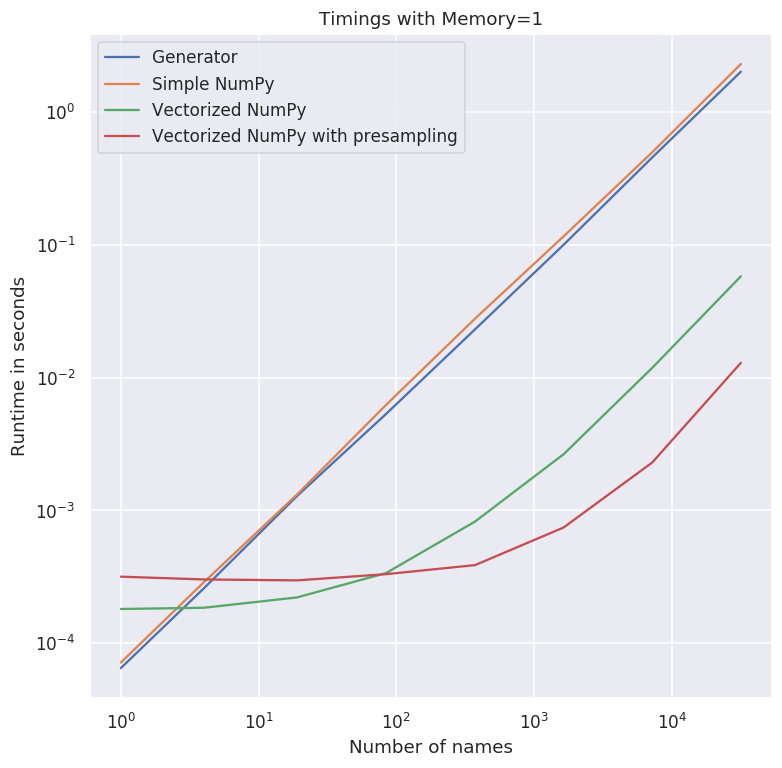

In [42]:
transition_matrix = create_transition_matrix(name_lists['egypt_gods'], memory=1)
cumulative_transition_matrix = np.cumsum(transition_matrix, axis=-1)

plot_sampling_measurements(samplers, labels, title="Timings with Memory=1")

Measuring timings for from_generator
Measuring timings for from_numpy
Measuring timings for from_vectorized
Measuring timings for from_presampled


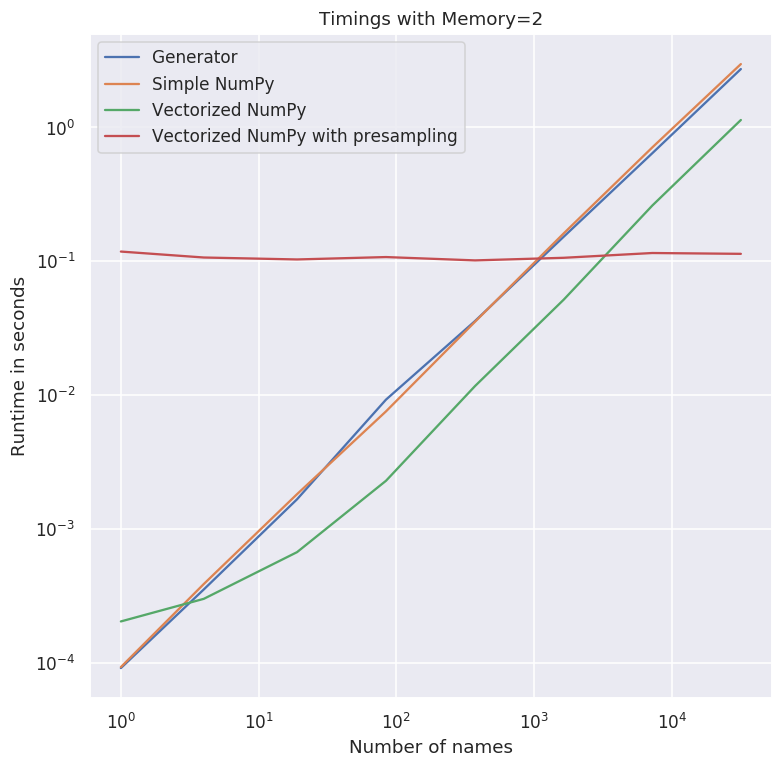

In [43]:
transition_matrix = create_transition_matrix(name_lists['egypt_gods'], memory=2)
cumulative_transition_matrix = np.cumsum(transition_matrix, axis=-1)

plot_sampling_measurements(samplers, labels, title="Timings with Memory=2")

In [44]:
%timeit from_presampled(10 ** 7)

6.48 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
